# Blood Glucose Predicition
Using historical blood glucose readings, insulin dosage, carbohydrate intake, and smartwatch activity data to predict future blood glucose. 

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from helper.helper import float_to_time, time_to_float, float_time_range, float_time_minus
import random
import tqdm
# Set seed for repeatability
def seed_everything(seed):
    np.random.seed(seed) # np random seed
    random.seed(seed) # py random seed
seed_everything(seed=1024)
import torch
print('torch version: ',torch.__version__)
print('Cuda available: ',torch.cuda.is_available())
print('Running on ',torch.cuda.get_device_name(torch.cuda.current_device()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch version:  2.5.1+cu124
Cuda available:  True
Running on  NVIDIA GeForce GTX 1060 6GB


Set the schema for the train and test sets to ensure correct types

In [2]:
train_schema = {
    'id': pl.String(),
    'p_num': pl.String(),
    'time': pl.Time(),
    'bg+1:00': pl.Float64()
    
}

for measurement_time in float_time_range(5.55,0.00,-0.05):
    train_schema[f'bg-{measurement_time}'] = pl.Float64()
    train_schema[f'insulin-{measurement_time}'] = pl.Float64()
    train_schema[f'carbs-{measurement_time}'] = pl.Float64()
    train_schema[f'hr-{measurement_time}'] = pl.Float64()
    train_schema[f'steps-{measurement_time}'] = pl.Float64()
    train_schema[f'cals-{measurement_time}'] = pl.Float64()
    train_schema[f'activity-{measurement_time}'] = pl.String()
    
test_schema = train_schema
del test_schema['bg+1:00']

Loading the test / train sets using polars

In [3]:
train_df = pl.read_csv('../../data/train.csv',
                       schema_overrides=pl.Schema(train_schema),
                       null_values = ['',' ','null','NaN','None']
)

test_df = pl.read_csv('../../data/test.csv',
                       schema_overrides=pl.Schema(test_schema),
                       null_values = ['',' ','null','NaN','None']
)
def load_data(path, schema):
    df = pl.read_csv(path,
                schema_overrides=pl.Schema(schema),
                null_values = ['',' ','null','NaN','None']
    )
    
    step_columns = [f'steps-{t}' for t in float_time_range(5.55, 0.00, -0.05)]

    df = df.with_columns(pl.col(step_columns).cast(pl.UInt32))
    df = df.to_dummies(columns=['p_num'])

    for measurement in ['insulin', 'carbs', 'steps', 'cals']:
        for time in float_time_range(5.55, 0.00, -0.05):
            df = df.with_columns(
                [pl.col(f'{measurement}-{time}').fill_null(0)]
            )
    return df

train_df = load_data('../../data/train.csv', train_schema)
test_df = load_data('../../data/test.csv', test_schema)

train_df.glimpse()

Rows: 177024
Columns: 516
$ id             <str> 'p01_0', 'p01_1', 'p01_2', 'p01_3', 'p01_4', 'p01_5', 'p01_6', 'p01_7', 'p01_8', 'p01_9'
$ p_num_p01       <u8> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ p_num_p02       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ p_num_p03       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ p_num_p04       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ p_num_p05       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ p_num_p06       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ p_num_p10       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ p_num_p11       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ p_num_p12       <u8> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ time          <time> 06:10:00, 06:25:00, 06:40:00, 06:55:00, 07:10:00, 07:25:00, 07:40:00, 07:55:00, 08:10:00, 08:25:00
$ bg-5:55        <f64> None, None, None, None, None, None, None, None, None, None
$ bg-5:50        <f64> None, None, None, None, None, None, None, None, None, None
$ bg-5:45        <f64> 9.6, 9.7, 9.2, 8.7, 8.4, 8.1, 8.3, 9.6, 11.1, 11.8
$ bg-5:40        <f64> None, None,

## Dataset Description

The dataset is from a study that 
- Collected data from young adults in the UK with type 1 diabetes, who used a continuous glucose monitor (CGM), an insulin pump and a smartwatch.
- These devices collected blood glucose readings, insulin dosage, carbohydrate intake, and activity data. 
- The data collected was aggregated to five-minute intervals and formatted into samples. 
- Each sample represents a point in time and includes the aggregated five-minute intervals from the previous six hours. 
- The aim is to predict the blood glucose reading an hour into the future, for each of these samples.

#### The Training Set
- Takes samples from the first three months of study data from nine of the participants and includes the future blood glucose value.
- These training samples appear in chronological order and overlap. 
#### The Testing Set
- Takes samples from the remainder of the study period from fifteen of the participants (so unseen participants appear in the testing set).
- These testing samples do not overlap and are in a random order to avoid data leakage.

### Complexities to be aware of:
- This is medical data so there are missing values and noise in the data
- The participants did not all use the same device models (CGM, insulin pump and smartwatch) so there may be differences in the collection method of the data
- Some participants in the test set do not appear in the training set

#### Files
* `activities.txt`: A list of activity names that appear in the `activity-X:XX` columns.
* `sample_submission.csv`: A sample submission file in the correct format.
* `test.csv`: The test set.
* `train.csv`: The training set.

### Training Features
| Feature | Description |
|---|---|
| `id` | row id consisting of participant number and a count for that participant |
| `p_num` | participant number |
| `time` | time of day in the format HH:MM:SS |
| `bg-X:XX` | blood glucose reading in mmol/L, X:XX(H:MM) time in the past (e.g. bg-2:35, would be the blood glucose reading from 2 hours and 35 minutes before the time value for that row), recorded by the continuous glucose monitor |
| `insulin-X:XX` | total insulin dose received in units in the last 5 minutes, X:XX(H:MM) time in the past (e.g. insulin-2:35, would be the total insulin dose received between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), recorded by the insulin pump |
| `carbs-X:XX` | total carbohydrate value consumed in grammes in the last 5 minutes, X:XX(H:MM) time in the past (e.g. carbs-2:35, would be the total carbohydrate value consumed between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), recorded by the participant |
| `hr-X:XX` | mean heart rate in beats per minute in the last 5 minutes, X:XX(H:MM) time in the past (e.g. hr-2:35, would be the mean heart rate between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), recorded by the smartwatch |
| `steps-X:XX` | total steps walked in the last 5 minutes, X:XX(H:MM) time in the past (e.g. steps-2:35, would be the total steps walked between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), recorded by the smartwatch |
| `cals-X:XX` | total calories burnt in the last 5 minutes, X:XX(H:MM) time in the past (e.g. cals-2:35, would be the total calories burned between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), calculated by the smartwatch |
| `activity-X:XX` | self-declared activity performed in the last 5 minutes, X:XX(H:MM) time in the past (e.g. activity-2:35, would show a string name of the activity performed between 2 hours and 40 minutes and 2 hours and 35 minutes before the time value for that row), set on the smartwatch |
| `bg+1:00` | blood glucose reading in mmol/L an hour in the future, this is the value you will be predicting (not provided in test.csv) |

normalisation, sliding windows?, use padding and masking? one hot encode patient id, normalise time columnn as important - sine cosine, hour of day, 


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'p_num_p01'),
  Text(1, 0, 'p_num_p02'),
  Text(2, 0, 'p_num_p03'),
  Text(3, 0, 'p_num_p04'),
  Text(4, 0, 'p_num_p05'),
  Text(5, 0, 'p_num_p06'),
  Text(6, 0, 'p_num_p10'),
  Text(7, 0, 'p_num_p11'),
  Text(8, 0, 'p_num_p12')])

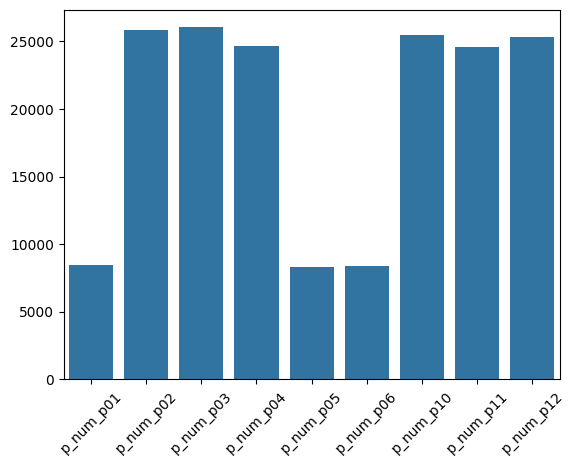

In [4]:
train_participants = ['p_num_p01','p_num_p02','p_num_p03','p_num_p04','p_num_p05','p_num_p06','p_num_p10','p_num_p11','p_num_p12']
visual = train_df[train_participants]
np_visual = visual.sum().to_numpy()
sns.barplot(x = train_participants, y = np_visual[0])
plt.xticks(rotation=45)

Interesting that there is less data for p01, p05, p06, maybe leave one out in training to test unseen performance? cv leaving a participant cv? leaving two out, stratified sample out, sample out, then ensamble them all either weighted avg, nn, or other

# First Basic Attempt
Lets train the model purely based on the blood glucose time history to sort out some kinks when training

First lets select the bg, time and person columns, lets limit it to only particiant 1 also

In [5]:
import statistics

def pattern_finder(sample_df: pl.DataFrame):
    df = sample_df
    
    missing_mask = df.select([pl.col(col).is_null().alias(col) for col in df.columns]).to_numpy()
    
    gaps = []
    gap_size = 0

    for column in missing_mask[0]:
        if column == 0:
            gaps.append(gap_size)
            gap_size = 0
        if column == 1:
            gap_size += 1
            
    for column in missing_mask[1]:
        if column == 0:
            gaps.append(gap_size)
            gap_size = 0
        if column == 1:
            gap_size += 1
    mode = statistics.mode(gaps)
    gaps = [x for x in gaps if x!= mode]
    if len(gaps) == 0:
        next_mode = -1 # here to signify no other missing data
    else:
        next_mode = statistics.mode(gaps)
    return mode,next_mode


In [6]:
metrics = ['bg','insulin','carbs','hr','steps','cals']# removed activity as categorical,'activity']
patterns = []
for participant in train_participants:
    for metric in metrics:
        sample_columns = [f'{metric}-{t}' for t in float_time_range(5.55,0.00,-0.05)]
        sample_columns = [f'{participant}','time'] + sample_columns + ['bg+1:00']
        sample_df = train_df[sample_columns].filter(pl.col(f'{participant}') == 1)
        pattern = pattern_finder(sample_df)
        patterns.append({'participant': participant, 'metric': metric, 'pattern': pattern})

patterns_df = pl.DataFrame(patterns)
patterns_df.filter(
    pl.col('pattern').list[0] > 0
)

participant,metric,pattern
str,str,list[i64]
"""p_num_p01""","""bg""","[2, 0]"
"""p_num_p05""","""bg""","[2, 0]"


From this pattern analysis we can see two clear groups with different recording frequencies for the blood glucose readings only, heavily hinting at different ontinuous glucose monitor devices. It is likely that the test set has a new monitor as the study is to generalise but this could be a potential feature.

Every 5 mins:
 - Participant 2
 - Participant 3
 - Participant 4
 - Participant 10
 - Participant 11
 - Participant 12

Every 15 Mins:
 - Participant 1
 - Participant 5 (with missing recordings at the start)
 - Participant 6 (with missing recordings at the start)


In [7]:
missed_readings_df = patterns_df.filter(
    pl.col('pattern').list[0] == 0,
    pl.col('pattern').list[1] > 0
).sort(pl.col('pattern').list[-1])
missed_readings_df


participant,metric,pattern
str,str,list[i64]
"""p_num_p06""","""bg""","[0, 2]"
"""p_num_p12""","""bg""","[0, 70]"
"""p_num_p01""","""hr""","[0, 72]"
"""p_num_p02""","""hr""","[0, 72]"
"""p_num_p03""","""hr""","[0, 72]"
"""p_num_p04""","""hr""","[0, 72]"
"""p_num_p05""","""hr""","[0, 72]"
"""p_num_p06""","""hr""","[0, 72]"
"""p_num_p10""","""hr""","[0, 72]"


We can also see a large trend where most of the tests have a 6 hour gap semi regularly, with almost all having this same gap, Im assuming this is for charging the device overnight currently.

Lets have a quick look at the test set now and see what intervals we have

In [8]:
metrics = ['bg','insulin','carbs','hr','steps','cals']# removed activity as categorical,'activity']
patterns = []
test_participants = ['p_num_p01','p_num_p02','p_num_p04','p_num_p05','p_num_p06','p_num_p10','p_num_p11','p_num_p12','p_num_p15','p_num_p16','p_num_p18','p_num_p19','p_num_p21','p_num_p22','p_num_p24']
for participant in test_participants:
    for metric in metrics:
        sample_columns = [f'{metric}-{t}' for t in float_time_range(5.55,0.00,-0.05)]
        sample_columns = [f'{participant}','time'] + sample_columns
        sample_df = test_df[sample_columns].filter(pl.col(f'{participant}') == 1)
        pattern = pattern_finder(sample_df)
        patterns.append({'participant': participant, 'metric': metric, 'pattern': pattern})

test_patterns_df = pl.DataFrame(patterns)
test_patterns_df.filter(
    pl.col('pattern').list[0] > 0,
    pl.col('metric') == 'bg'
)

participant,metric,pattern
str,str,list[i64]
"""p_num_p01""","""bg""","[2, 0]"
"""p_num_p05""","""bg""","[2, 0]"
"""p_num_p06""","""bg""","[2, 0]"


In [9]:
test_patterns_df.filter(
    pl.col('pattern').list[0] > 0,
    pl.col('pattern').list[1] == 0,
    pl.col('metric') == 'bg'
)

participant,metric,pattern
str,str,list[i64]
"""p_num_p01""","""bg""","[2, 0]"
"""p_num_p05""","""bg""","[2, 0]"
"""p_num_p06""","""bg""","[2, 0]"


Now there are some columns that are categorical that need to be sorted out, lets fix the time column

I want to convert it to seconds, then normalise it

In [10]:
def time_to_seconds(df, column = 'time'):
    
    return df.with_columns(
        (
            pl.col(column)
            .cast(pl.String)
            .str.split(':')
            .list.get(0).cast(pl.Int64).mul(3600) +  # hours to seconds
            pl.col(column)
            .cast(pl.String)
            .str.split(':')
            .list.get(1).cast(pl.Int64).mul(60) +  # minutes to seconds
            pl.col(column)
            .cast(pl.String)
            .str.split(':')
            .list.get(2).cast(pl.Int64)  # seconds
        ).alias(f'{column}_in_seconds')
    )
def normalise_time(df, column='time'):
    seconds_in_day = 24 * 60 * 60
    df = time_to_seconds(df, column)
    return df.with_columns(
        (pl.col(f'{column}_in_seconds') / seconds_in_day).alias('normalised_time')
    ).drop([column, f'{column}_in_seconds'])
    
    
    
sample_df = normalise_time(sample_df)
sample_df['normalised_time']

normalised_time
f64
0.690972
0.541667
0.829861
0.944444
0.826389
…
0.277778
0.520833
0.15625


In [11]:
sample_tensor = sample_df.to_torch()

<Axes: ylabel='Count'>

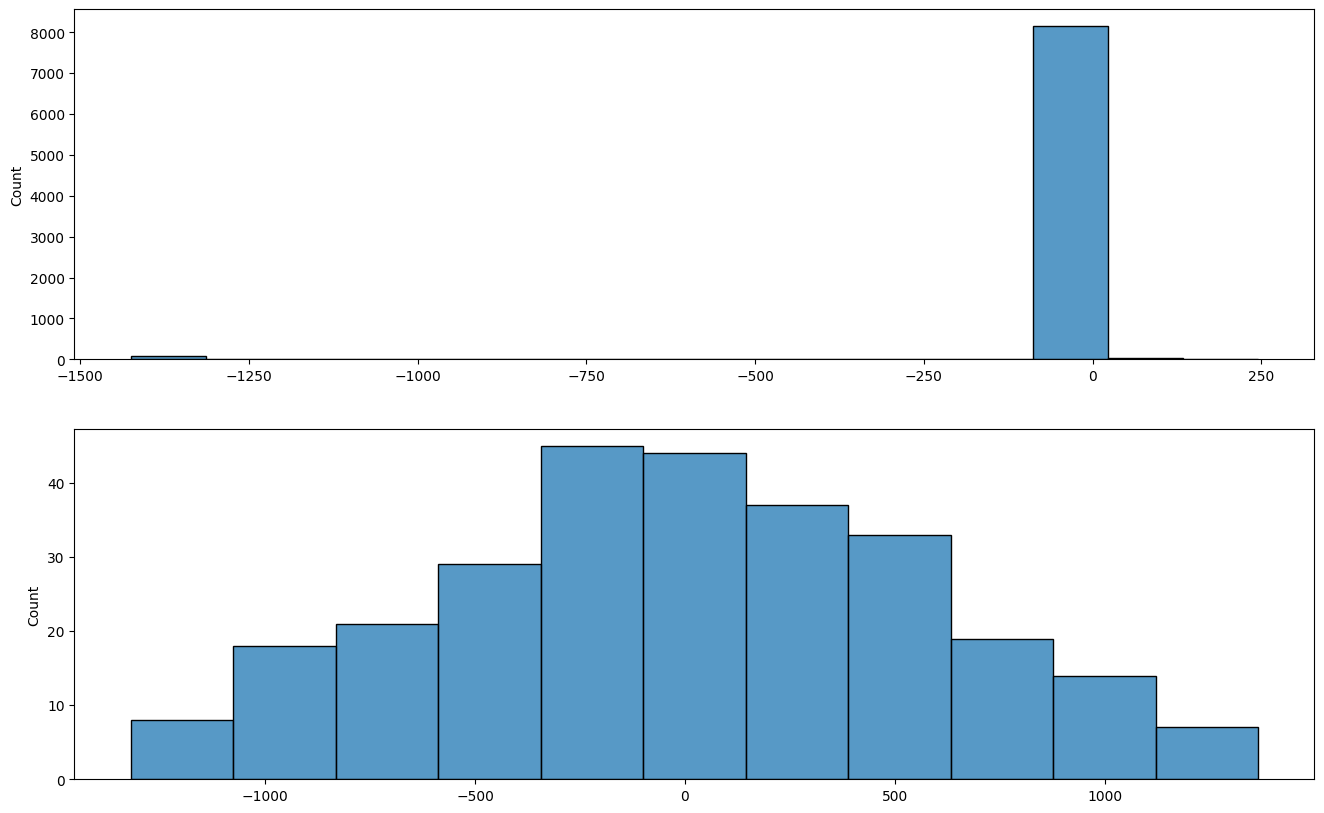

In [12]:
def calculate_time_differences(df, p_num_id='p_num_p01'):

    filtered_time = df.filter(pl.col(p_num_id) == 1).select('time')

    filtered_time = filtered_time.with_columns(
        pl.col('time').shift(-1).alias('time n+1')
    )

    filtered_time = time_to_seconds(filtered_time, column='time')
    filtered_time = time_to_seconds(filtered_time, column='time n+1')

    filtered_time = filtered_time.with_columns(
        ((pl.col('time n+1_in_seconds') - pl.col('time_in_seconds')) / 60).alias('time_diff')
    )
    return filtered_time

p_num_id = 'p_num_p05'
train_td = calculate_time_differences(train_df,p_num_id)
test_td = calculate_time_differences(test_df,p_num_id)

plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
sns.histplot(train_td['time_diff'])

plt.subplot(2,1,2)
sns.histplot(test_td['time_diff'])


In [13]:
lstm_features = [
    'id', 'p_num_p01', 'p_num_p02', 'p_num_p03', 'p_num_p04', 'p_num_p05', 'p_num_p06',
    'p_num_p10', 'p_num_p11', 'p_num_p12', 'bg', 'insulin', 'carbs', 'hr', 'steps', 
    'cals', 'Run', 'Strength training', 'Swim', 'Bike', 'Dancing', 'Stairclimber', 
    'Spinning', 'Walking', 'HIIT', 'Outdoor Bike', 'Walk', 'Aerobic Workout', 'Tennis', 
    'Workout', 'Hike', 'Zumba', 'Sport', 'Yoga', 'Swimming', 'Weights', 'Running'
]
lstm_target = ['bg+1:00']

lstm_schema = {
    'id': pl.String,
    'time_delta': pl.Float64,
    'time': pl.Float64,  
    'p_num_p01': pl.Boolean, 
    'p_num_p02': pl.Boolean,
    'p_num_p03': pl.Boolean,
    'p_num_p04': pl.Boolean,
    'p_num_p05': pl.Boolean,
    'p_num_p06': pl.Boolean,
    'p_num_p10': pl.Boolean,
    'p_num_p11': pl.Boolean,
    'p_num_p12': pl.Boolean,
    'bg': pl.Float64,  
    'insulin': pl.Float64,
    'carbs': pl.Float64,
    'hr': pl.Float64,  
    'steps': pl.Float64, 
    'cals': pl.Float64,  
    'Run': pl.Boolean,
    'Strength training': pl.Boolean,
    'Swim': pl.Boolean,
    'Bike': pl.Boolean,
    'Dancing': pl.Boolean,
    'Stairclimber': pl.Boolean,
    'Spinning': pl.Boolean,
    'Walking': pl.Boolean,
    'HIIT': pl.Boolean,
    'Outdoor Bike': pl.Boolean,
    'Walk': pl.Boolean,
    'Aerobic Workout': pl.Boolean,
    'Tennis': pl.Boolean,
    'Workout': pl.Boolean,
    'Hike': pl.Boolean,
    'Zumba': pl.Boolean,
    'Sport': pl.Boolean,
    'Yoga': pl.Boolean,
    'Swimming': pl.Boolean,
    'Weights': pl.Boolean,
    'Running': pl.Boolean,
    'bg+1:00': pl.Float64
}

In [14]:
time_range = float_time_range(5.55, 0.00, -0.05)
float_minute_percent = 10/6
def melt_row(melter_row):
    rows = []
    for m_time in time_range:
        m_time_float = time_to_float(m_time)
        m_time_hours = int(m_time_float)
        m_time_minutes = (m_time_float - m_time_hours) * float_minute_percent
        current_activity = melter_row[f'activity-{m_time}'][0]
        row = {
            'id'               : melter_row['id'][0],
            'time_delta'       : 1.0 if m_time == '0:00' else 5/60,
            'time'             : (( melter_row['time'][0].hour + melter_row['time'][0].minute / 60 ) - (m_time_hours + m_time_minutes)) % 24, 
            'p_num_p01'        : melter_row['p_num_p01'][0], 
            'p_num_p02'        : melter_row['p_num_p02'][0],
            'p_num_p03'        : melter_row['p_num_p03'][0],
            'p_num_p04'        : melter_row['p_num_p04'][0], 
            'p_num_p05'        : melter_row['p_num_p05'][0],
            'p_num_p06'        : melter_row['p_num_p06'][0],
            'p_num_p10'        : melter_row['p_num_p10'][0],
            'p_num_p11'        : melter_row['p_num_p11'][0],
            'p_num_p12'        : melter_row['p_num_p12'][0],
            'bg'               : melter_row[f'bg-{m_time}'][0], 
            'insulin'          : melter_row[f'insulin-{m_time}'][0], 
            'carbs'            : melter_row[f'carbs-{m_time}'][0],
            'hr'               : melter_row[f'hr-{m_time}'][0],
            'steps'            : melter_row[f'steps-{m_time}'][0], 
            'cals'             : melter_row[f'cals-{m_time}'][0],
            'Run'              : 1 if current_activity == 'Run' else 0,
            'Strength training': 1 if current_activity == 'Strength training' else 0,
            'Swim'             : 1 if current_activity == 'Swim' else 0,
            'Bike'             : 1 if current_activity == 'Bike' else 0, 
            'Dancing'          : 1 if current_activity == 'Dancing' else 0,
            'Stairclimber'     : 1 if current_activity == 'Stairclimber' else 0,
            'Spinning'         : 1 if current_activity == 'Spinning' else 0,
            'Walking'          : 1 if current_activity == 'Walking' else 0,
            'HIIT'             : 1 if current_activity == 'HIIT' else 0,
            'Outdoor Bike'     : 1 if current_activity == 'Outdoor Bike' else 0,
            'Walk'             : 1 if current_activity == 'Walk' else 0,
            'Aerobic Workout'  : 1 if current_activity == 'Aerobic Workout' else 0,
            'Tennis'           : 1 if current_activity == 'Tennis' else 0,
            'Workout'          : 1 if current_activity == 'Workout' else 0,
            'Hike'             : 1 if current_activity == 'Hike' else 0,
            'Zumba'            : 1 if current_activity == 'Zumba' else 0,
            'Sport'            : 1 if current_activity == 'Sport' else 0,
            'Yoga'             : 1 if current_activity == 'Yoga' else 0,
            'Swimming'         : 1 if current_activity == 'Swimming' else 0,
            'Weights'          : 1 if current_activity == 'Weights' else 0,
            'Running'          : 1 if current_activity == 'Running' else 0,
            'bg+1:00'          : melter_row['bg+1:00'][0]
        }
        rows.append(row)
    return rows

lstm_schema = {
    'id': pl.String,
    'time_delta': pl.Float64,
    'time': pl.Float64,  
    'p_num_p01': pl.Boolean, 
    'p_num_p02': pl.Boolean,
    'p_num_p03': pl.Boolean,
    'p_num_p04': pl.Boolean,
    'p_num_p05': pl.Boolean,
    'p_num_p06': pl.Boolean,
    'p_num_p10': pl.Boolean,
    'p_num_p11': pl.Boolean,
    'p_num_p12': pl.Boolean,
    'bg': pl.Float64,  
    'insulin': pl.Float64,
    'carbs': pl.Float64,
    'hr': pl.Float64,  
    'steps': pl.Float64, 
    'cals': pl.Float64,
    'Run': pl.Boolean,
    'Strength training': pl.Boolean,
    'Swim': pl.Boolean,
    'Bike': pl.Boolean,
    'Dancing': pl.Boolean,
    'Stairclimber': pl.Boolean,
    'Spinning': pl.Boolean,
    'Walking': pl.Boolean,
    'HIIT': pl.Boolean,
    'Outdoor Bike': pl.Boolean,
    'Walk': pl.Boolean,
    'Aerobic Workout': pl.Boolean,
    'Tennis': pl.Boolean,
    'Workout': pl.Boolean,
    'Hike': pl.Boolean,
    'Zumba': pl.Boolean,
    'Sport': pl.Boolean,
    'Yoga': pl.Boolean,
    'Swimming': pl.Boolean,
    'Weights': pl.Boolean,
    'Running': pl.Boolean,
    'bg+1:00': pl.Float64
}

output_file = '../../data/lstm_train.csv'
is_first_write = True
all_rows = []
for melter_row in tqdm.tqdm(range(train_df.shape[0]), desc="Processing rows"):
    all_rows.extend(melt_row(train_df[int(melter_row)]))
    

    if melter_row % 100 == 0 or melter_row == train_df.shape[0] - 1:
        lstm_df = pl.DataFrame(all_rows, schema=lstm_schema)
        all_rows = []
        
        if is_first_write:
            lstm_df.write_csv(output_file, include_header=True)
            is_first_write = False
        else:
            with open(output_file, 'a') as f:
                lstm_df.write_csv(f, include_header=False)


Processing rows: 100%|██████████| 177024/177024 [11:52<00:00, 248.42it/s]


Need to figure out what normalisation and what to do with all the missing values.

In [15]:
output_file = '../../data/lstm_train.csv'
lstm_df = pl.read_csv(output_file, schema_overrides=lstm_schema)
lstm_df.describe()

statistic,id,time_delta,time,p_num_p01,p_num_p02,p_num_p03,p_num_p04,p_num_p05,p_num_p06,p_num_p10,p_num_p11,p_num_p12,bg,insulin,carbs,hr,steps,cals,Run,Strength training,Swim,Bike,Dancing,Stairclimber,Spinning,Walking,HIIT,Outdoor Bike,Walk,Aerobic Workout,Tennis,Workout,Hike,Zumba,Sport,Yoga,Swimming,Weights,Running,bg+1:00
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""12745728""",1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.1374044e7,1.2745728e7,1.2745728e7,9.036634e6,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7,1.2745728e7
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.371684e6,0.0,0.0,3.709094e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,0.096065,11.926472,0.047784,0.14615,0.147031,0.13945,0.046819,0.047355,0.143788,0.13871,0.142913,8.236099,0.192198,0.695743,79.314833,24.489425,7.481751,0.001378,0.000019,0.000232,0.000034,0.00008,0.000002,0.000011,0.001287,0.000058,0.000243,0.011157,0.00013,0.000009,0.000054,0.000113,0.00003,0.00044,0.000051,0.000034,0.000027,0.000047,8.277045
"""std""",null,0.107277,6.912417,null,null,null,null,null,null,null,null,null,2.906333,0.990758,7.437724,18.036637,77.925658,8.086336,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2.99639
"""min""","""p01_0""",0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2,-0.3078,0.0,37.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2
"""25%""",null,0.083333,5.916667,null,null,null,null,null,null,null,null,null,6.1,0.0292,0.0,64.8,0.0,4.55,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,6.1
"""50%""",null,0.083333,11.916667,null,null,null,null,null,null,null,null,null,7.6,0.0729,0.0,77.5,0.0,5.95,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,7.7
"""75%""",null,0.083333,17.916667,null,null,null,null,null,null,null,null,null,9.8,0.1083,0.0,90.0,6.0,7.7,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,9.9
"""max""","""p12_9999""",1.0,24.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,27.8,46.311,852.0,185.3,1359.0,116.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,27.8


Training xgboost to predict missing heart rate values

In [16]:
import polars as pl
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

best_params = { # obtained from hyperparameter tuning on google colab
    'subsample': 1.0,
    'n_estimators': 200,
    'max_depth': 10,
    'learning_rate': 0.2,
    'colsample_bytree': 0.8
}

final_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    device='cuda',
    **best_params
)

feature_cols = [
    'time', 'Run', 'Strength training', 'Swim', 'Bike', 'Dancing',
    'Stairclimber', 'Spinning', 'Walking', 'HIIT', 'Outdoor Bike',
    'Walk', 'Aerobic Workout', 'Tennis', 'Workout', 'Hike',
    'Zumba', 'Sport', 'Yoga', 'Swimming', 'Weights', 'Running',
    'p_num_p01', 'p_num_p02', 'p_num_p03', 'p_num_p04',
    'p_num_p05', 'p_num_p06', 'p_num_p10', 'p_num_p11', 'p_num_p12'
]

df_clean = lstm_df.filter(pl.col('hr').is_not_null())
X = df_clean.select(feature_cols)
y = df_clean.select('hr')
X_np = X.to_numpy()
y_np = y.to_numpy().ravel()

final_model.fit(X_np, y_np)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [17]:
df_missing_hr = lstm_df.filter(pl.col('hr').is_null())

X_missing = df_missing_hr.select(feature_cols)
X_missing_np = X_missing.to_numpy()

predicted_hr = final_model.predict(X_missing_np)
predicted_hr_lst = [hr for hr in predicted_hr]


/home/jamie/Documents/bloodGlucosePrediciton/bg_pred/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:01:51] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Switch to pandas to imputate the predictions

In [18]:
lstm_pd = lstm_df.to_pandas()

predicted_hr_lst_copy = pd.Series(predicted_hr_lst)

missing_mask = lstm_pd['hr'].isnull() 
missing_count = missing_mask.sum()
print(f"Number of missing 'hr' values: {missing_count}")

if missing_count > 0:
    lstm_pd.loc[missing_mask, 'hr'] = predicted_hr_lst_copy[:missing_count].values

lstm_pd.to_csv("../../data/lstm_hr_train.csv", index=False)

Number of missing 'hr' values: 3709094


In [19]:
lstm_hr_df = pl.read_csv('../../data/lstm_hr_train.csv',schema_overrides=lstm_schema)
lstm_hr_df

id,time_delta,time,p_num_p01,p_num_p02,p_num_p03,p_num_p04,p_num_p05,p_num_p06,p_num_p10,p_num_p11,p_num_p12,bg,insulin,carbs,hr,steps,cals,Run,Strength training,Swim,Bike,Dancing,Stairclimber,Spinning,Walking,HIIT,Outdoor Bike,Walk,Aerobic Workout,Tennis,Workout,Hike,Zumba,Sport,Yoga,Swimming,Weights,Running,bg+1:00
str,f64,f64,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64
"""p01_0""",0.083333,0.25,true,false,false,false,false,false,false,false,false,null,0.0083,0.0,68.520874,0.0,0.0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,13.4
"""p01_0""",0.083333,0.333333,true,false,false,false,false,false,false,false,false,null,0.0083,0.0,68.994675,0.0,0.0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,13.4
"""p01_0""",0.083333,0.416667,true,false,false,false,false,false,false,false,false,9.6,0.0083,0.0,68.916794,0.0,0.0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,13.4
"""p01_0""",0.083333,0.5,true,false,false,false,false,false,false,false,false,null,0.0083,0.0,67.358681,0.0,0.0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,13.4
"""p01_0""",0.083333,0.583333,true,false,false,false,false,false,false,false,false,null,0.0083,0.0,67.358681,0.0,0.0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,13.4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""p12_25298""",0.083333,23.583333,false,false,false,false,false,false,false,false,true,9.8,0.275,0.0,92.580383,0.0,6.75,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,10.2
"""p12_25298""",0.083333,23.666667,false,false,false,false,false,false,false,false,true,10.3,1.06,0.0,90.676529,0.0,6.75,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,10.2
"""p12_25298""",0.083333,23.75,false,false,false,false,false,false,false,false,true,10.7,0.56,0.0,89.493073,0.0,6.75,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,10.2


### Wheter to drop null bg values or not?
Lets have a look at the distribution of null bg values in each recording sesssion (id)

Text(0, 0.5, 'Cumulative Probability')

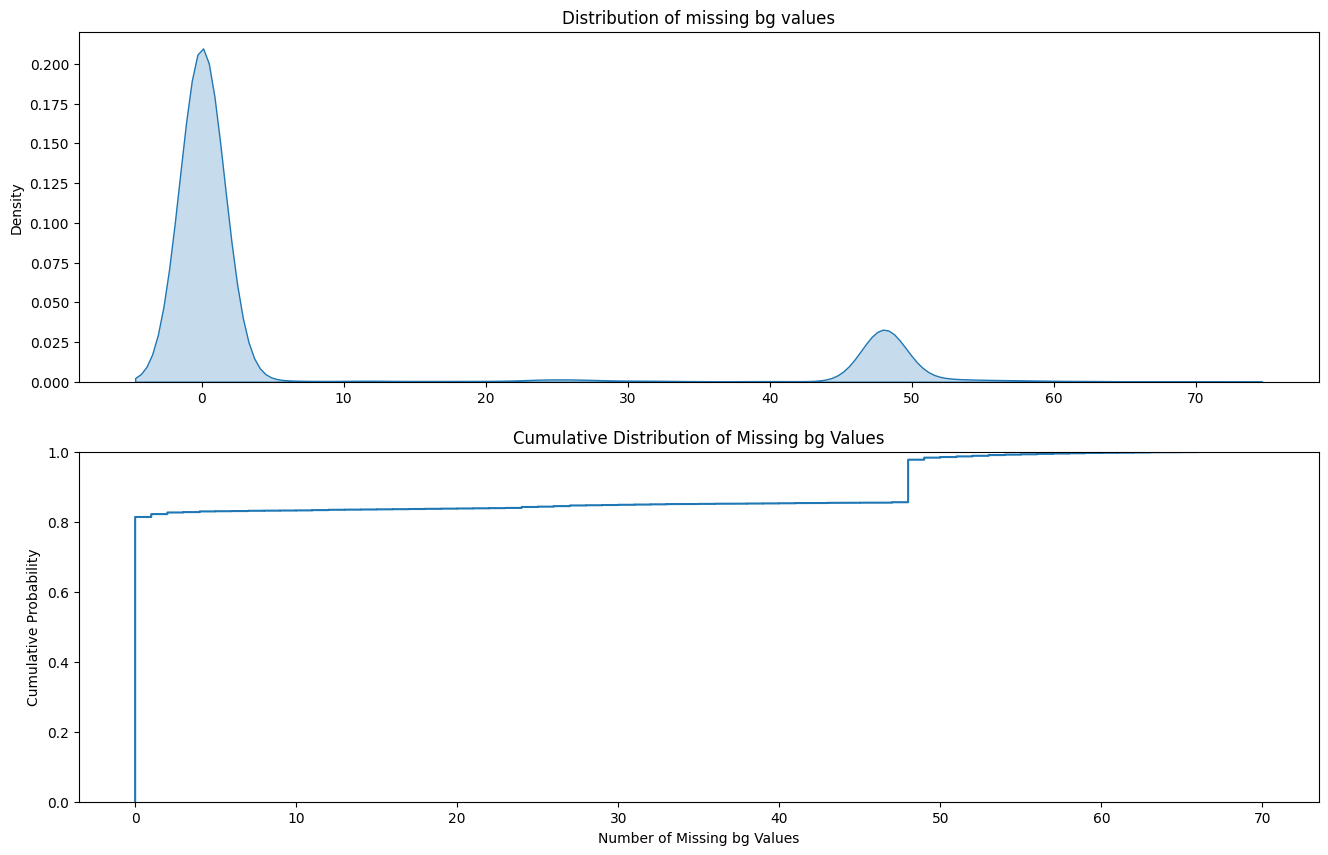

In [20]:
null_bg = lstm_hr_df.group_by('id').agg(
    pl.col('bg').null_count().alias('null_count')
).sort('null_count', descending=True)

plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
sns.kdeplot(null_bg['null_count'].to_numpy(), fill=True)
plt.title('Distribution of missing bg values')

plt.subplot(2,1,2)
sns.ecdfplot(null_bg['null_count'].to_numpy())
plt.title('Cumulative Distribution of Missing bg Values')
plt.xlabel('Number of Missing bg Values')
plt.ylabel('Cumulative Probability')

Around 80% of the data has no / low numbers of missing bg values, as the rest is very high at around 65% missing values we will just drop this 20% seeting a threshold at 0 missing data points

In [21]:
print('total datapoints: ',null_bg.count()['null_count'][0])
print('datapoints with less than 30 / 72 null values: ',null_bg.filter(pl.col('null_count') < 30).count()['null_count'][0])   
print('datapoints with less than 10 / 72 null values: ',null_bg.filter(pl.col('null_count') < 10).count()['null_count'][0])   
print('datapoints with less than 5 / 72 null values: ',null_bg.filter(pl.col('null_count') < 5).count()['null_count'][0])   
print('datapoints with 0 null values: ',null_bg.filter(pl.col('null_count') == 0).count()['null_count'][0], 'or when not grouped by id: ',null_bg.filter(pl.col('null_count') == 0).count()['null_count'][0] * 72)



total datapoints:  177024
datapoints with less than 30 / 72 null values:  150066
datapoints with less than 10 / 72 null values:  147280
datapoints with less than 5 / 72 null values:  146834
datapoints with 0 null values:  144016 or when not grouped by id:  10369152


dropping any values with more than 0 null values

In [22]:
id_list = null_bg.filter(pl.col('null_count') > 0).select('id')
lstm_hr_df = lstm_hr_df.filter(~pl.col('id').is_in(id_list['id']))
lstm_hr_df.shape

(10369152, 40)

## Normalising the data
normalising time, insulin, carbs, hr, steps and cals to help training stability. I have used min max scaling as most of my approaches will be nueral network based and values between 0-1 train well

In [23]:
from sklearn.preprocessing import MinMaxScaler


columns_to_normalise = ["time", "insulin", "carbs", "hr", "steps", "cals"] # removed bg columns as they should be normalised together

data_to_normalize = lstm_hr_df.select(columns_to_normalise).to_numpy()

scaler = MinMaxScaler()

normalised_data = scaler.fit_transform(data_to_normalize)

lstm_hr_df = lstm_hr_df.with_columns(
    [pl.Series(columns_to_normalise[i], normalised_data[:, i]) for i in range(len(columns_to_normalise))]
)

lstm_hr_df


id,time_delta,time,p_num_p01,p_num_p02,p_num_p03,p_num_p04,p_num_p05,p_num_p06,p_num_p10,p_num_p11,p_num_p12,bg,insulin,carbs,hr,steps,cals,Run,Strength training,Swim,Bike,Dancing,Stairclimber,Spinning,Walking,HIIT,Outdoor Bike,Walk,Aerobic Workout,Tennis,Workout,Hike,Zumba,Sport,Yoga,Swimming,Weights,Running,bg+1:00
str,f64,f64,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64
"""p02_0""",0.083333,0.006944,false,true,false,false,false,false,false,false,false,9.5,0.008284,0.0,0.225317,0.0,0.0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,7.1
"""p02_0""",0.083333,0.010417,false,true,false,false,false,false,false,false,false,9.6,0.008338,0.0,0.225827,0.0,0.0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,7.1
"""p02_0""",0.083333,0.013889,false,true,false,false,false,false,false,false,false,9.6,0.008572,0.0,0.226764,0.0,0.0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,7.1
"""p02_0""",0.083333,0.017361,false,true,false,false,false,false,false,false,false,9.9,0.008299,0.0,0.226595,0.0,0.0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,7.1
"""p02_0""",0.083333,0.020833,false,true,false,false,false,false,false,false,false,10.1,0.023036,0.0,0.226131,0.0,0.0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,7.1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""p12_25298""",0.083333,0.982639,false,false,false,false,false,false,false,false,true,9.8,0.012501,0.0,0.361875,0.0,0.05814,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,10.2
"""p12_25298""",0.083333,0.986111,false,false,false,false,false,false,false,false,true,10.3,0.02934,0.0,0.348772,0.0,0.05814,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,10.2
"""p12_25298""",0.083333,0.989583,false,false,false,false,false,false,false,false,true,10.7,0.018615,0.0,0.340627,0.0,0.05814,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,10.2


Normalising the bg columns together

In [24]:
bg_columns = ['bg', 'bg+1:00']
bg_max = max(lstm_hr_df['bg'].max(), lstm_hr_df['bg+1:00'].max())
bg_min = min(lstm_hr_df['bg'].min(), lstm_hr_df['bg+1:00'].min())

bg_data = lstm_hr_df.select(bg_columns).to_numpy()

bg_scaler = MinMaxScaler()
bg_scaler.fit([[bg_min, bg_min], [bg_max, bg_max]])

bg_normalised = bg_scaler.transform(bg_data)

lstm_hr_df = lstm_hr_df.with_columns(
    [pl.Series(bg_columns[i], bg_normalised[:, i]) for i in range(len(bg_columns))]
)

lstm_hr_df

id,time_delta,time,p_num_p01,p_num_p02,p_num_p03,p_num_p04,p_num_p05,p_num_p06,p_num_p10,p_num_p11,p_num_p12,bg,insulin,carbs,hr,steps,cals,Run,Strength training,Swim,Bike,Dancing,Stairclimber,Spinning,Walking,HIIT,Outdoor Bike,Walk,Aerobic Workout,Tennis,Workout,Hike,Zumba,Sport,Yoga,Swimming,Weights,Running,bg+1:00
str,f64,f64,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64
"""p02_0""",0.083333,0.006944,false,true,false,false,false,false,false,false,false,0.365,0.008284,0.0,0.225317,0.0,0.0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,0.245
"""p02_0""",0.083333,0.010417,false,true,false,false,false,false,false,false,false,0.37,0.008338,0.0,0.225827,0.0,0.0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,0.245
"""p02_0""",0.083333,0.013889,false,true,false,false,false,false,false,false,false,0.37,0.008572,0.0,0.226764,0.0,0.0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,0.245
"""p02_0""",0.083333,0.017361,false,true,false,false,false,false,false,false,false,0.385,0.008299,0.0,0.226595,0.0,0.0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,0.245
"""p02_0""",0.083333,0.020833,false,true,false,false,false,false,false,false,false,0.395,0.023036,0.0,0.226131,0.0,0.0,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,0.245
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""p12_25298""",0.083333,0.982639,false,false,false,false,false,false,false,false,true,0.38,0.012501,0.0,0.361875,0.0,0.05814,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,0.4
"""p12_25298""",0.083333,0.986111,false,false,false,false,false,false,false,false,true,0.405,0.02934,0.0,0.348772,0.0,0.05814,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,0.4
"""p12_25298""",0.083333,0.989583,false,false,false,false,false,false,false,false,true,0.425,0.018615,0.0,0.340627,0.0,0.05814,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,0.4


### Formatting the data for pytorch / lstm
For lstm using pytorch the tensor should be in the format (seq_length, batch_size, input_features)

therefore to access a data point, we use tensor_data[sequence_point, batch_number, feature_index]

In [25]:
lstm_by_id = (lstm_hr_df
    .group_by('id')
    .agg(pl.all())
)

In [26]:
lstm_hr_df.select('time_delta').describe()

statistic,time_delta
str,f64
"""count""",1.0369152e7
"""null_count""",0.0
"""mean""",0.096065
"""std""",0.107277
"""min""",0.083333
"""25%""",0.083333
"""50%""",0.083333
"""75%""",0.083333
"""max""",1.0


Get the features in the correct tensor format

In [27]:
lstm_df = lstm_by_id.drop(['id'])
lstm_np = np.stack([
    np.array(lstm_df[col].to_list(), 
            dtype=bool if lstm_df[col].dtype == pl.Boolean else np.float32) 
    for col in lstm_df.columns
])
lstm_tensor = torch.from_numpy(lstm_np)

In [28]:
# currently in the form [feature, batch_number,sequence_position]
t_lstm_tensor = lstm_tensor[-1,:,0]
t_lstm_tensor = t_lstm_tensor.reshape(-1,1)
t_lstm_tensor.shape

torch.Size([144016, 1])

In [29]:
X_lstm_tensor = lstm_tensor[:-1,:,:]
X_lstm_tensor = X_lstm_tensor.permute(1,2,0)
X_lstm_tensor.shape

torch.Size([144016, 72, 38])

In [31]:
X_lstm_tensor.shape, t_lstm_tensor.shape

(torch.Size([144016, 72, 38]), torch.Size([144016, 1]))

In [32]:
# in form tensor_data[sequence_point, batch_number, feature_index]
torch.save(X_lstm_tensor,'../../data/X_lstm.pt')
torch.save(t_lstm_tensor,'../../data/t_lstm.pt')

## Building the LSTM Model

In [33]:
X_lstm_tensor = torch.load('../../data/X_lstm.pt',weights_only=False)
t_lstm_tensor = torch.load('../../data/t_lstm.pt',weights_only=False)

In [34]:
X_lstm_tensor.shape, t_lstm_tensor.shape

(torch.Size([144016, 72, 38]), torch.Size([144016, 1]))

In [35]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(X_lstm_tensor, t_lstm_tensor)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [36]:
for X, t in train_loader:
    print('X.shape:', X.shape, 't.shape:', t.shape)
    break
for X, t in val_loader:
    print('X.shape:', X.shape, 't.shape:', t.shape)
    break
for X, t in test_loader:
    print('X.shape:', X.shape, 't.shape:', t.shape)
    break

X.shape: torch.Size([32, 72, 38]) t.shape: torch.Size([32, 1])
X.shape: torch.Size([32, 72, 38]) t.shape: torch.Size([32, 1])
X.shape: torch.Size([32, 72, 38]) t.shape: torch.Size([32, 1])


In [37]:
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        last_hidden_state = output[:, -1, :]
        prediction = self.fc(last_hidden_state)
        return prediction
    

In [82]:
import torch.optim as optim
import numpy as np

INPUT_SIZE = X_lstm_tensor.shape[-1]
HIDDEN_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 30

LSTMReg = LSTMRegressor(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE)
LSTMReg.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(LSTMReg.parameters(), lr=0.001)

def calculate_rmse(predictions, targets):
    mse = criterion(predictions, targets)
    return torch.sqrt(mse)

for epoch in range(EPOCHS):
    LSTMReg.train() 
    
    running_loss = 0.0 
    train_rmse = 0.0
    for X_batch, t_batch in train_loader:
        X_batch, t_batch = X_batch.to(device), t_batch.to(device)

        optimizer.zero_grad()

        predictions = LSTMReg(X_batch)

        loss = criterion(predictions, t_batch)
        
        combined_data = np.hstack([t_batch.cpu().detach().numpy(), predictions.cpu().detach().numpy()])
        t_batch_inverse, predictions_inverse = bg_scaler.inverse_transform(combined_data).T
        t_batch_inverse = torch.from_numpy(t_batch_inverse).to(device)
        predictions_inverse = torch.from_numpy(predictions_inverse).to(device)
        
        train_rmse += calculate_rmse(predictions_inverse, t_batch_inverse).item()

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_rmse /= len(train_loader)
    
    LSTMReg.eval() 
    val_rmse = 0.0
    with torch.no_grad():
        for X_val_batch, t_val_batch in val_loader:
            X_val_batch, t_val_batch = X_val_batch.to(device), t_val_batch.to(device)
            
            val_predictions = LSTMReg(X_val_batch)

            combined_data = np.hstack([t_val_batch.cpu().numpy(), val_predictions.cpu().numpy()])
            t_val_batch_inverse, val_predictions_inverse = bg_scaler.inverse_transform(combined_data).T
            t_val_batch_inverse = torch.from_numpy(t_val_batch_inverse).to(device)
            val_predictions_inverse = torch.from_numpy(val_predictions_inverse).to(device)

            val_rmse += calculate_rmse(val_predictions_inverse, t_val_batch_inverse).item()

    val_rmse /= len(val_loader)

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}")

torch.save(LSTMReg.state_dict(), "lstm_regressor.pth")


Epoch [1/30], Train RMSE: 1.9741, Val RMSE: 1.9197
Epoch [2/30], Train RMSE: 1.8587, Val RMSE: 1.8136
Epoch [3/30], Train RMSE: 1.8273, Val RMSE: 1.8120
Epoch [4/30], Train RMSE: 1.8106, Val RMSE: 1.7955
Epoch [5/30], Train RMSE: 1.7969, Val RMSE: 1.7751
Epoch [6/30], Train RMSE: 1.7828, Val RMSE: 1.7588
Epoch [7/30], Train RMSE: 1.7681, Val RMSE: 1.7466
Epoch [8/30], Train RMSE: 1.7589, Val RMSE: 1.7575
Epoch [9/30], Train RMSE: 1.7419, Val RMSE: 1.7262
Epoch [10/30], Train RMSE: 1.7310, Val RMSE: 1.7443
Epoch [11/30], Train RMSE: 1.7162, Val RMSE: 1.7161
Epoch [12/30], Train RMSE: 1.7019, Val RMSE: 1.7096
Epoch [13/30], Train RMSE: 1.6854, Val RMSE: 1.6928
Epoch [14/30], Train RMSE: 1.6716, Val RMSE: 1.7120
Epoch [15/30], Train RMSE: 1.6558, Val RMSE: 1.6577
Epoch [16/30], Train RMSE: 1.6423, Val RMSE: 1.6527
Epoch [17/30], Train RMSE: 1.6277, Val RMSE: 1.6537
Epoch [18/30], Train RMSE: 1.6145, Val RMSE: 1.6451
Epoch [19/30], Train RMSE: 1.6004, Val RMSE: 1.6132
Epoch [20/30], Train 

In [86]:
LSTMReg.eval()

squared_error_total = 0.0  
num_samples = 0 

with torch.no_grad():
    for X_test_batch, t_test_batch in test_loader:
        X_test_batch, t_test_batch = X_test_batch.to(device), t_test_batch.to(device)
        
        test_predictions = LSTMReg(X_test_batch)
        
        t_test_batch = t_test_batch.view(-1, 1)
        test_predictions = test_predictions.view(-1, 1)

        combined_data = np.hstack([t_test_batch.cpu().numpy(), test_predictions.cpu().numpy()])
        
        t_test_batch_inverse, test_predictions_inverse = bg_scaler.inverse_transform(combined_data).T
        t_test_batch_inverse = torch.from_numpy(t_test_batch_inverse)
        test_predictions_inverse = torch.from_numpy(test_predictions_inverse)


        squared_error = (test_predictions_inverse - t_test_batch_inverse) ** 2

        squared_error_total += squared_error.sum().item() 
        num_samples += len(t_test_batch_inverse)  


average_squared_error = squared_error_total / num_samples


test_rmse = np.sqrt(average_squared_error)

print(f"Test RMSE: {test_rmse:.4f}")


Test RMSE: 1.4887


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

LSTMReg.eval()

test_rmse = 0.0
num_batches = 0

all_targets = []
all_predictions = []

with torch.no_grad():  
    for X_test_batch, t_test_batch in test_loader:
        X_test_batch, t_test_batch = X_test_batch.to(device), t_test_batch.to(device)
        
        test_predictions = LSTMReg(X_test_batch)
        
        t_test_batch = t_test_batch.view(-1, 1)
        test_predictions = test_predictions.view(-1, 1)

        combined_data = np.hstack([t_test_batch.cpu().numpy(), test_predictions.cpu().numpy()])
        
        t_test_batch_inverse, test_predictions_inverse = bg_scaler.inverse_transform(combined_data).T
        t_test_batch_inverse = torch.from_numpy(t_test_batch_inverse)
        test_predictions_inverse = torch.from_numpy(test_predictions_inverse)

        all_targets.append(t_test_batch_inverse.cpu().numpy())
        all_predictions.append(test_predictions_inverse.cpu().numpy())

        test_rmse += calculate_rmse(test_predictions_inverse, t_test_batch_inverse).item()
        num_batches += 1


all_targets = np.concatenate(all_targets)
all_predictions = np.concatenate(all_predictions)


test_rmse /= num_batches
print(f"Test RMSE: {test_rmse:.4f}")

sorted_indices = np.argsort(all_targets)  
sorted_targets = all_targets[sorted_indices] 
sorted_predictions = all_predictions[sorted_indices]  
print(len(sorted_targets), len(sorted_predictions))


Test RMSE: 1.4685
14402 14402


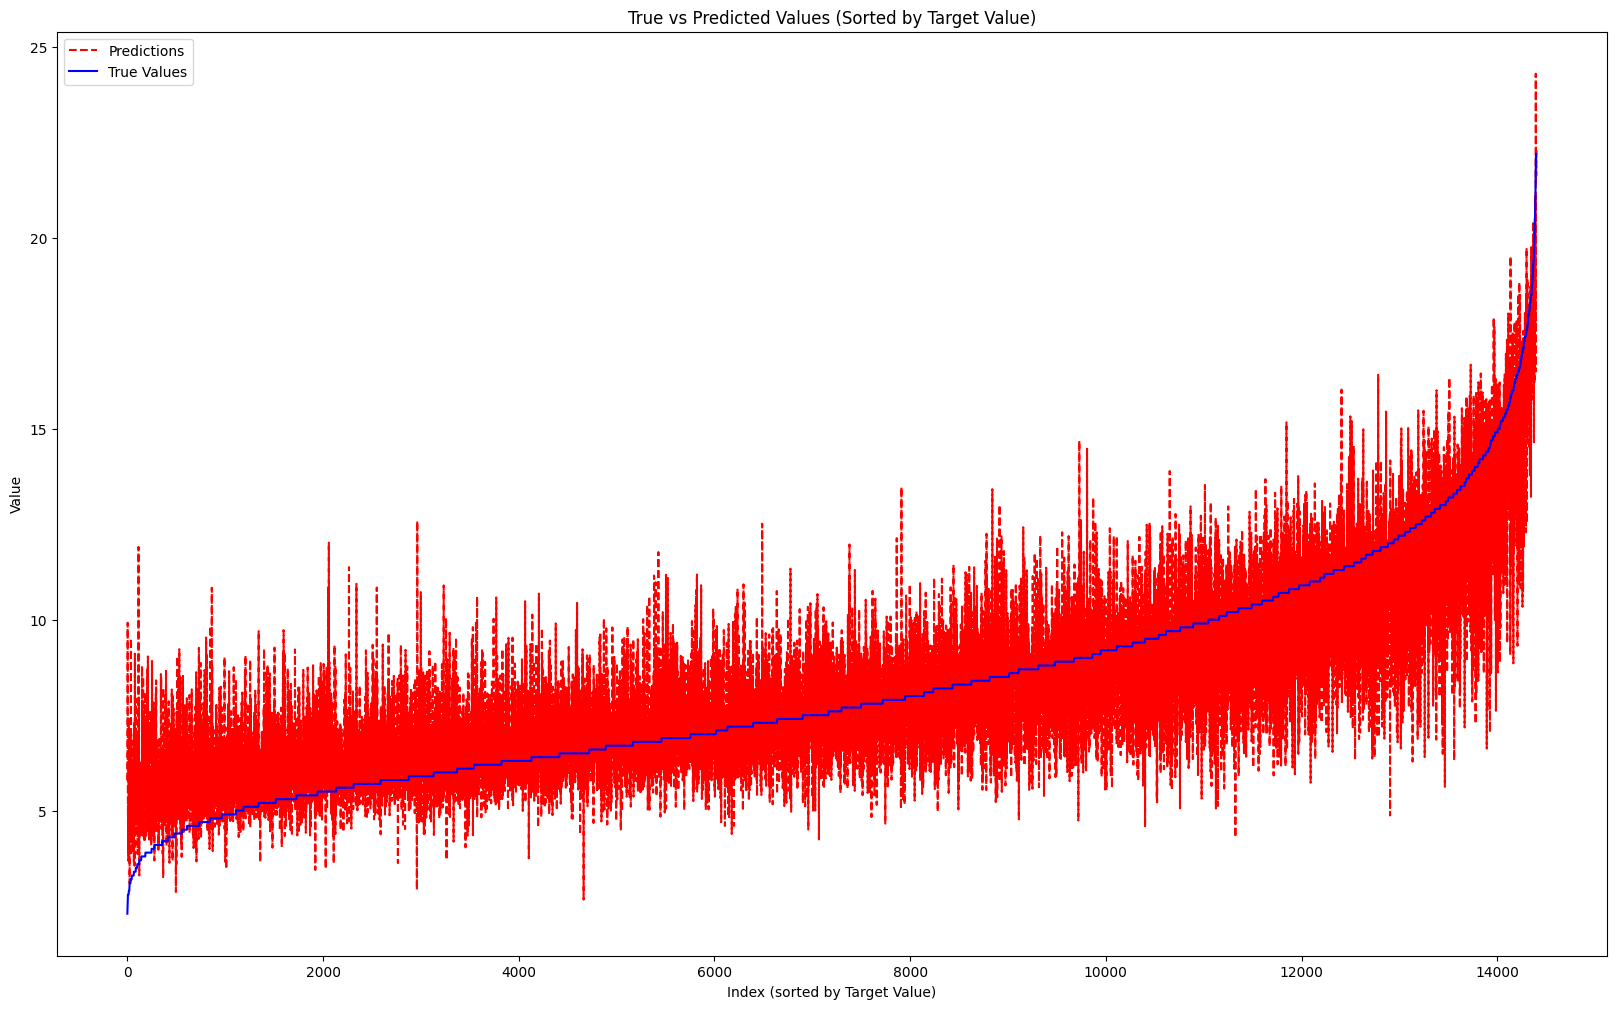

In [88]:
start,end = 0, len(sorted_targets)
plt.figure(figsize=(20, 12))
plt.plot(sorted_predictions[start:end], label='Predictions', color='red', linestyle='--')
plt.plot(sorted_targets[start:end], label='True Values', color='blue')

plt.xlabel('Index (sorted by Target Value)')
plt.ylabel('Value')
plt.title('True vs Predicted Values (Sorted by Target Value)')
plt.legend()
plt.show()